<font size="6">Prospective Study of Blood Biomarkers for Diabetes Prediction</font>

- Author: Shaun Chen
- Last modified: 2024-09-23
- Description: This project analyzes blood biomarkers to identify those associated with the development of diabetes and builds a machine learning model to predict diabetes risk. The work involves data cleaning, statistical analysis, and model evaluation to provide insights into diabetes progression and prediction.

# Data Loading and Setup

## Import Libraries

In [1]:
# Automatically reload modules before execution to reflect changes.
%load_ext autoreload
%autoreload 2

# Data manipulation
import os
import numpy as np
import pandas as pd

# Statistical analysis
from scipy import stats
import statsmodels.api as sm

# Regex for pattern matching
import re

# Tracking and debugging
import logging

# Set inline visualization
import matplotlib.pyplot as plt
plt.set_loglevel('WARNING')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import visualization
import seaborn as sns
sns.set_style('white')
from matplotlib_venn import venn2

# Import necessary libraries for ML pipeline development
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Import necessary libraries for ML model evaluation
import shap
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve
)

# Import necessary libraries for models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Import non-linear estimator for alternative imputation
from sklearn.ensemble import RandomForestRegressor

# Import optimizer for hyperparameter tuning
import optuna

# Add src to the system path to access utility functions
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))

# Import custom functions
from src.utils import setup_logging
from src.data_utils import load_data, impute_data
from src.analysis_utils import *
from src.model_utils import *
from src.visualization_utils import *

## Configuration Settings

In [2]:
# Set up logging
setup_logging("INFO")

# Set up random seed
my_random_seed = 19770525 # cuz of "A New Hope"!!
np.random.seed(my_random_seed)

# Define file path and columns
raw_data_path = '../data/raw/test_project_data.csv'
id_column = 'subject_id'
categorical_columns = [
    'subject_id', 
    'sex',
    'prevalent_diabetes', 
    'incident_diabetes'
]
numeric_columns = [
    'age', 
    'BMI', 
    'diabetes_followup_time'
]
biomarker_pattern = '^mtb_'

main_dir = str(Path().resolve().parent)

## Load and Inspect Dataset

In [3]:
# Load data with `pyarrow` (4x faster)
raw_df = load_data(
    raw_data_path = raw_data_path,
    id_column = id_column,
    categorical_columns = categorical_columns,
    numeric_columns = numeric_columns,
    biomarker_pattern = biomarker_pattern
)

biomarker_cols = [col for col in raw_df.columns if re.search(biomarker_pattern, col)]

# Display the first few rows of the dataset
logging.info("Dataset preview:")
raw_df.head()

2024-09-24 00:41:35,387 - INFO - Dataset shape: (8291, 10006)
2024-09-24 00:41:35,395 - INFO - Dataset preview:


,mtb_0018261,mtb_0018266,mtb_0018325,mtb_0018326,mtb_0018327,mtb_0018351,mtb_0018362,mtb_0018470,mtb_0018509,mtb_0018536,...,mtb_2127305,mtb_2129124,mtb_2129210,mtb_2129554,BMI,age,sex,prevalent_diabetes,incident_diabetes,diabetes_followup_time
subject_id,,,,,,,,,,,,,,,,,,,,,
sbj_0000,5885.011,15177.95,19653.31,12611.670,9042.063,NaN,60124.56,9552.881,NaN,46704.90,...,NaN,NaN,22112.25,NaN,18.664268,33.81,male,0.0,0.0,14.77
sbj_0001,7624.425,10901.94,12129.36,9336.460,21680.930,NaN,83700.80,15068.120,NaN,21729.51,...,NaN,NaN,NaN,NaN,28.175977,68.56,male,0.0,0.0,14.77
sbj_0002,7220.400,18086.69,23707.55,7344.697,26314.650,NaN,82482.38,13911.300,NaN,22320.58,...,15185.790,NaN,19425.35,NaN,22.971959,55.68,male,0.0,0.0,14.77
sbj_0003,6797.486,12364.85,17775.76,25836.150,30563.140,NaN,92839.12,11690.130,NaN,10374.07,...,NaN,NaN,NaN,NaN,21.960370,43.89,female,0.0,0.0,14.78
sbj_0004,NaN,19046.33,18701.06,14137.270,27020.920,NaN,85453.69,9579.896,NaN,15700.81,...,5318.547,NaN,NaN,NaN,40.454949,47.76,male,0.0,0.0,14.86


# Data Preprocessing

## Missingness Distribution Overview

count    10006.000000
mean         0.489971
std          0.348249
min          0.000000
25%          0.121397
50%          0.528284
75%          0.823664
max          0.994452
dtype: float64


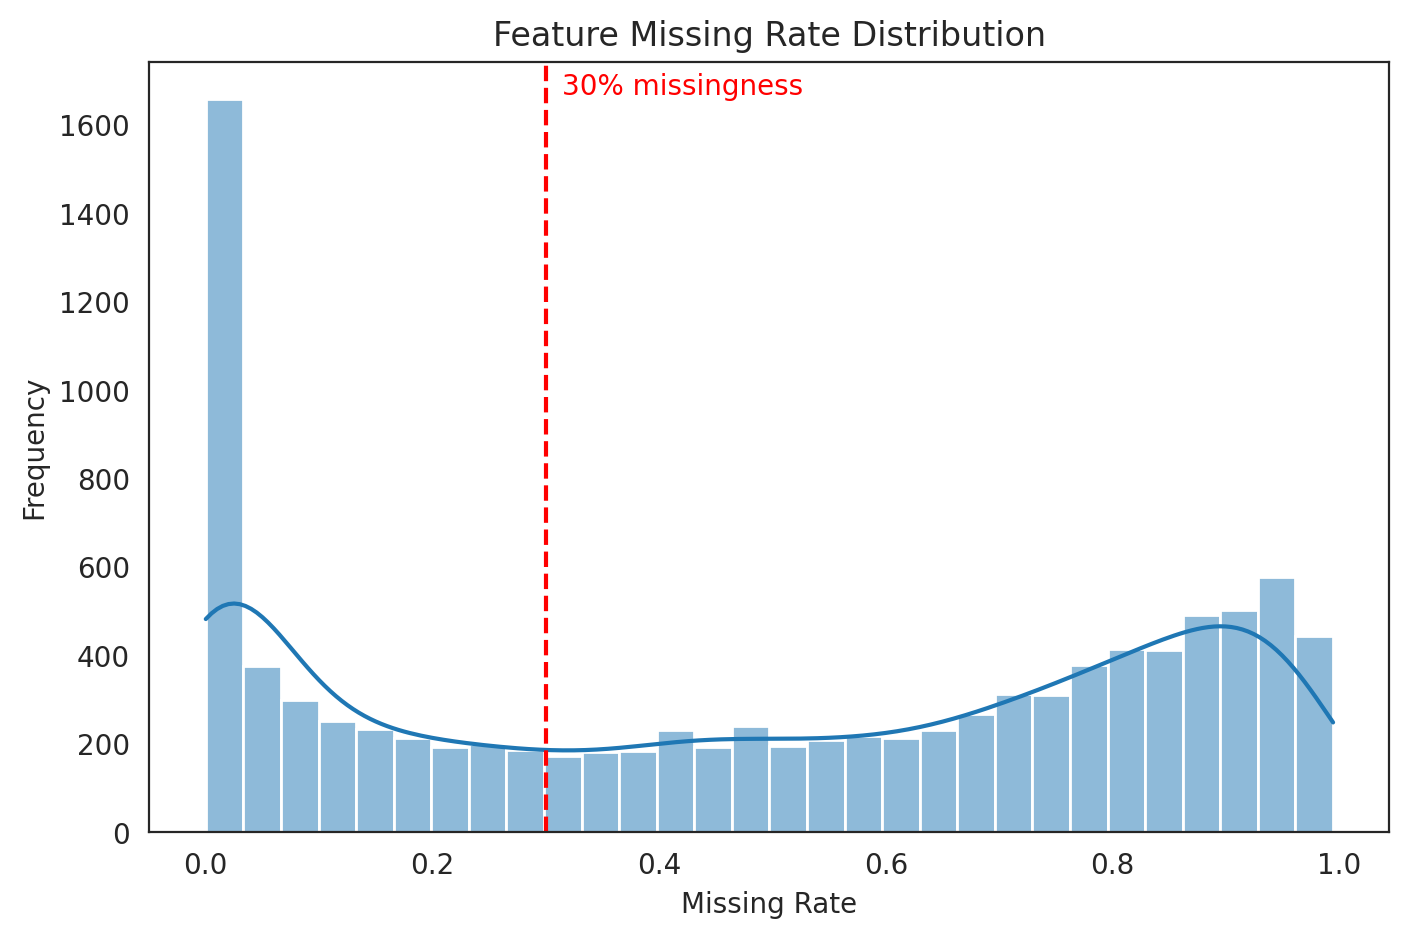

In [4]:
# Feature missing rate distribution
feature_missing_rate_arr = raw_df.isna().mean(axis=0)
print(feature_missing_rate_arr.describe())

plot_distribution(
    data=raw_df.isna().mean(axis=0).to_frame(name='missing_rate'),
    column='missing_rate',
    xlabel='Missing Rate',
    plot_type='histplot',
    axvline=0.3,
    axvline_text='30% missingness',
    text_offset = (0.01, 0),
    title = "Feature Missing Rate Distribution"
)

count    8291.000000
mean        0.489971
std         0.031056
min         0.420248
25%         0.468819
50%         0.485609
75%         0.506146
max         0.743054
dtype: float64


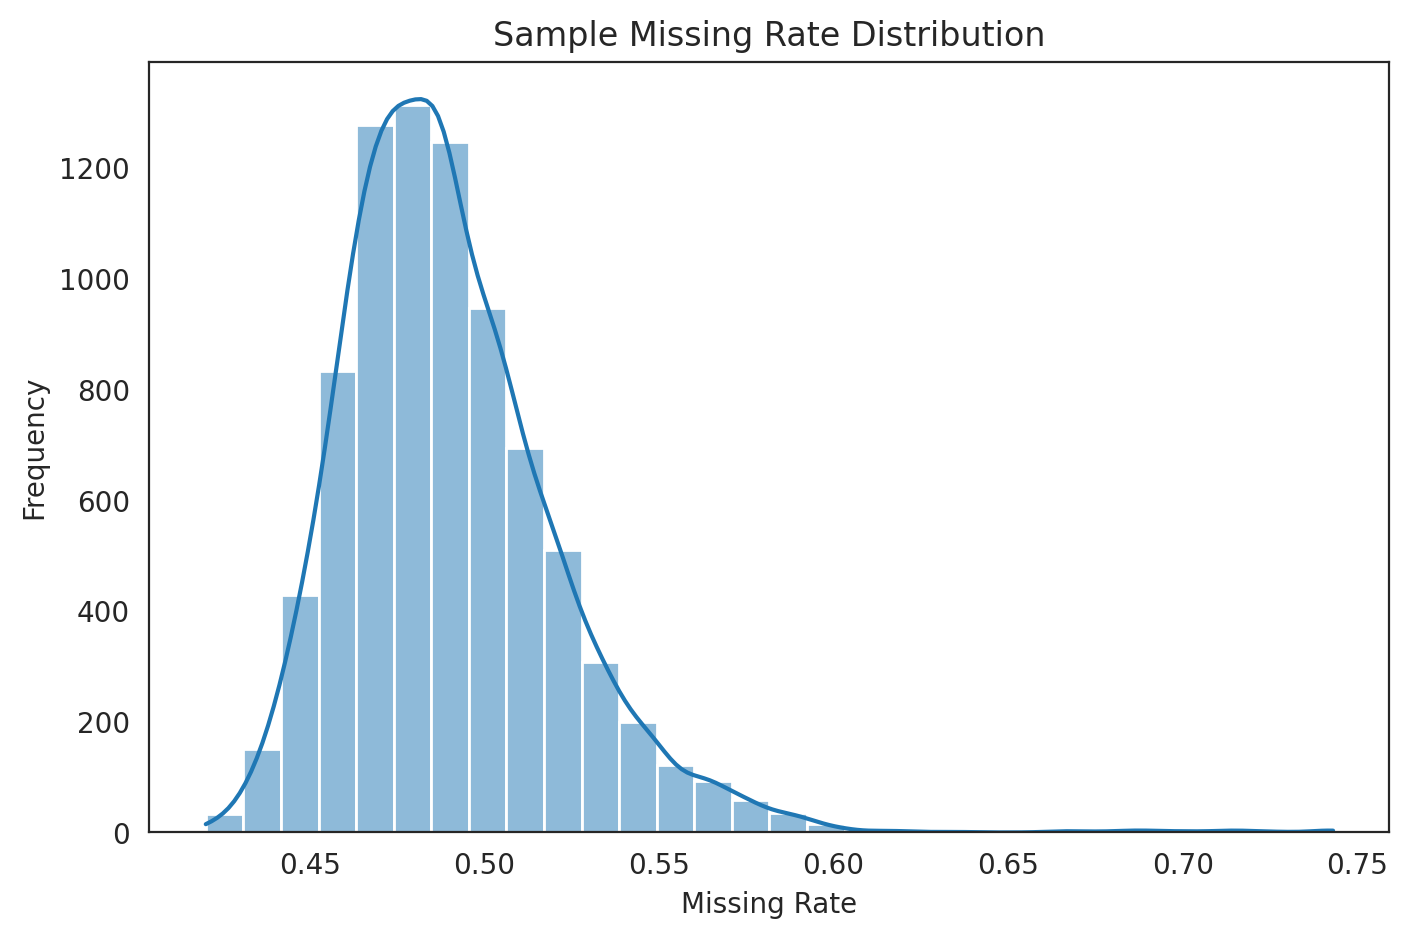

In [5]:
# Sample missing rate distribution
sample_missing_rate_arr = raw_df.isna().mean(axis=1)
print(sample_missing_rate_arr.describe())

plot_distribution(
    data=raw_df.isna().mean(axis=1).to_frame(name='missing_rate'), 
    column='missing_rate', 
    xlabel='Missing Rate',
    plot_type='histplot',
    title = "Sample Missing Rate Distribution"
)

## Diabetes-Related Columns: Label Consistency Checks

In [6]:
# Occruences of prevalent and incident diabetes
print(raw_df.value_counts(['prevalent_diabetes', 'incident_diabetes']))

# Check 1: A subject should not have both prevalent and incident diabetes at the same time
assert raw_df.loc[~(raw_df['incident_diabetes'].isna()) & (raw_df['incident_diabetes'] != 0) & (raw_df['prevalent_diabetes'] != 0), ].empty, \
    "Check failed: There are subjects who have both prevalent and incident diabetes. A subject shouldn't have both at the same time."

# Check 2: If a subject has non-positive follow-up time, they should have prevalent diabetes
assert raw_df.loc[(raw_df['diabetes_followup_time'] <= 0) & (raw_df['prevalent_diabetes'] != 1), ].empty, \
    "Check failed: There are subjects with negative follow-up time who do not have prevalent diabetes."

# Check 3: If a subject has non-positive follow-up time, they should not have incident diabetes
assert raw_df.loc[(raw_df['diabetes_followup_time'] <= 0) & (raw_df['incident_diabetes'] != 0), ].empty, \
    "Check failed: There are subjects with negative follow-up time who have incident diabetes."

prevalent_diabetes  incident_diabetes
0.0                 0.0                  6993
                    1.0                   704
1.0                 0.0                   451
Name: count, dtype: int64


prevalent_diabetes
0.0    7697
1.0     451
Name: count, dtype: int64


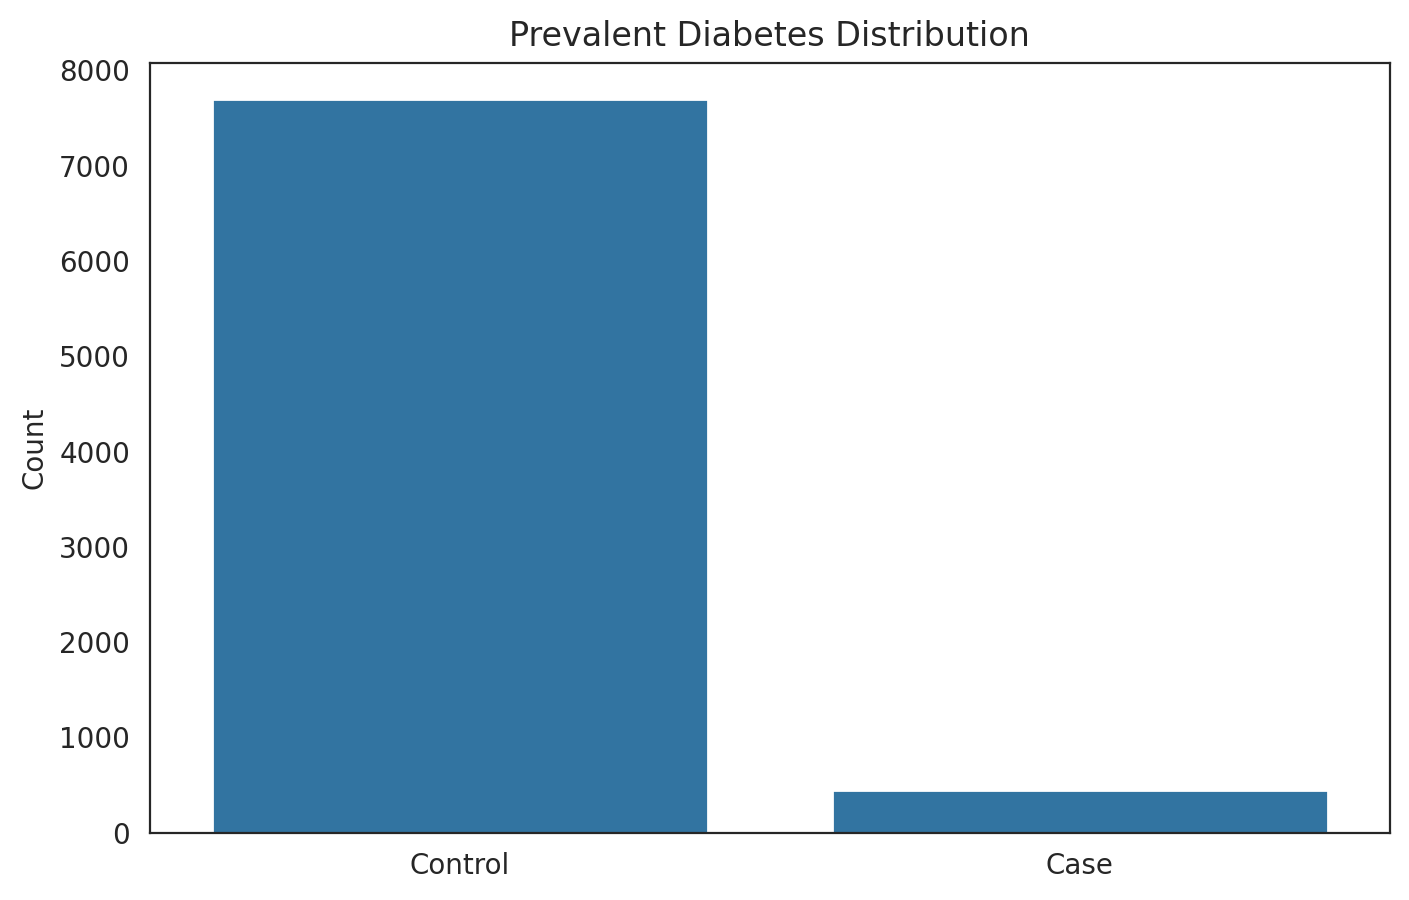

In [7]:
# Check prevalent diabetes distribution
print(raw_df['prevalent_diabetes'].value_counts())

plot_distribution(
    data=raw_df,
    column='prevalent_diabetes',
    plot_type='countplot',
    xticks=['Control', 'Case'],
    title = 'Prevalent Diabetes Distribution'
)

incident_diabetes
0.0    7444
1.0     704
Name: count, dtype: int64


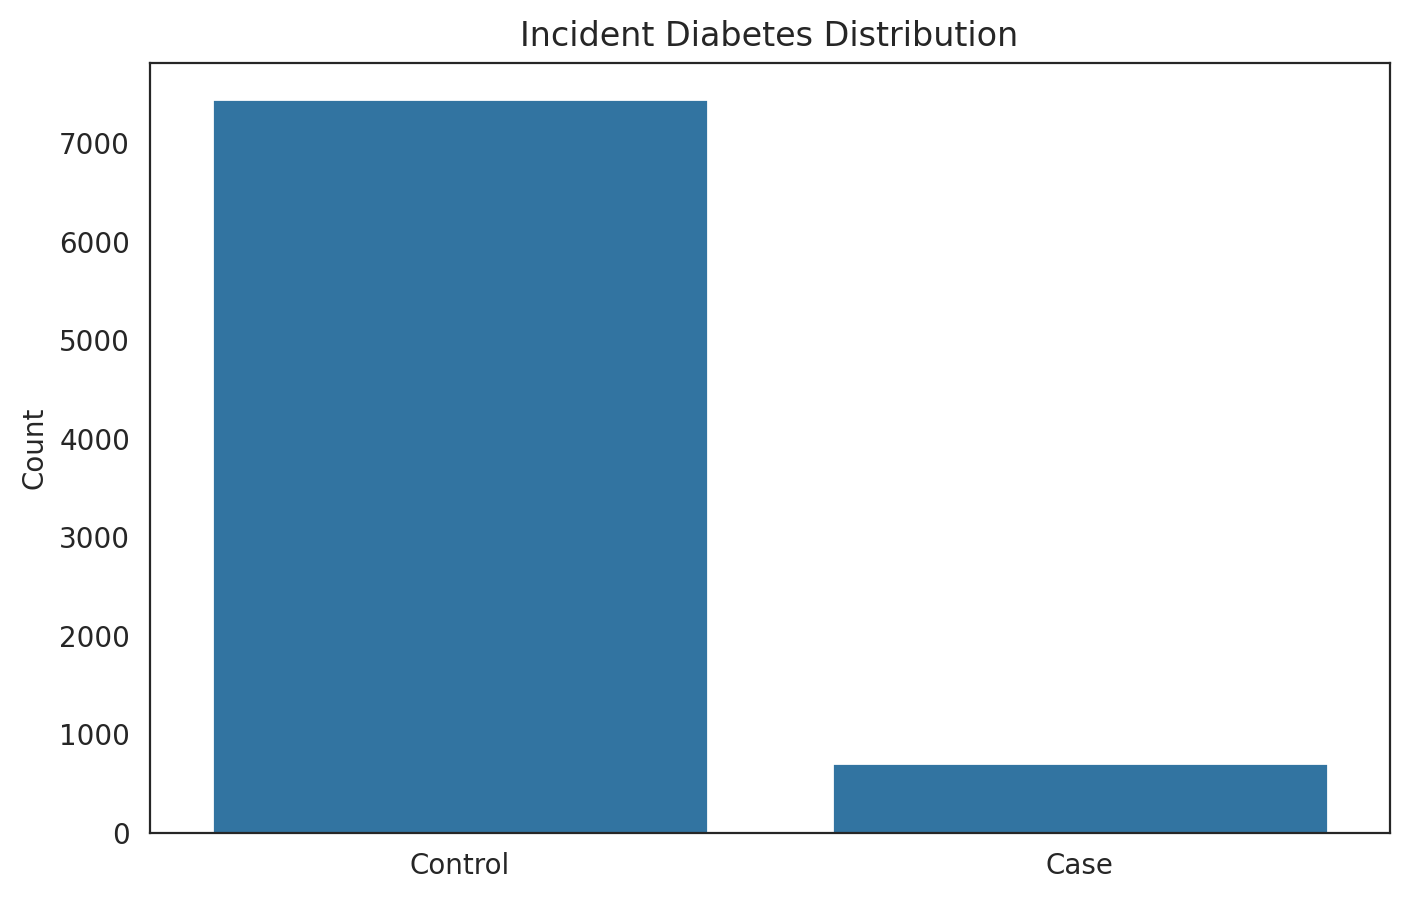

In [8]:
# Check incident diabetes distribution
print(raw_df['incident_diabetes'].value_counts())

plot_distribution(
    data=raw_df,
    column='incident_diabetes',
    plot_type='countplot',
    xticks=['Control', 'Case'],
    title = 'Incident Diabetes Distribution'
)

count    7979.000000
mean       12.959853
std         5.229209
min       -37.510000
25%        14.740000
50%        14.820000
75%        14.880000
max        14.960000
Name: diabetes_followup_time, dtype: float64


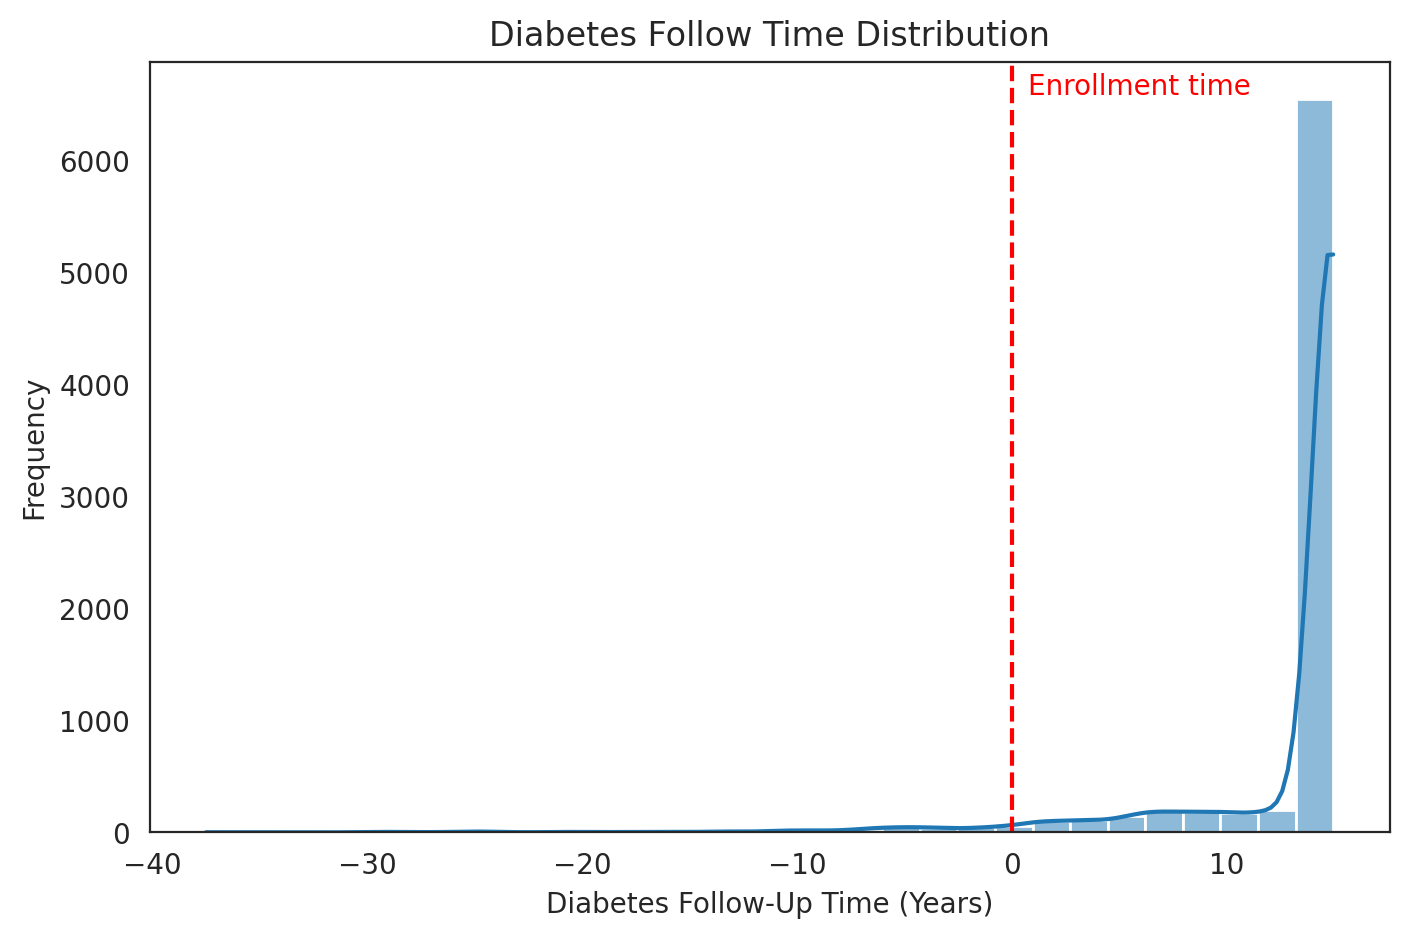

In [9]:
# Check diabetes follow time distribution

print(raw_df['diabetes_followup_time'].describe())

plot_distribution(
    data=raw_df,
    column='diabetes_followup_time',
    xlabel='Diabetes Follow-Up Time (Years)',
    plot_type='histplot',
    axvline=0,
    text_offset=(0.5, 0),
    axvline_text='Enrollment time',
    title='Diabetes Follow Time Distribution'
)

## Visualizing Skewness Before Transformation

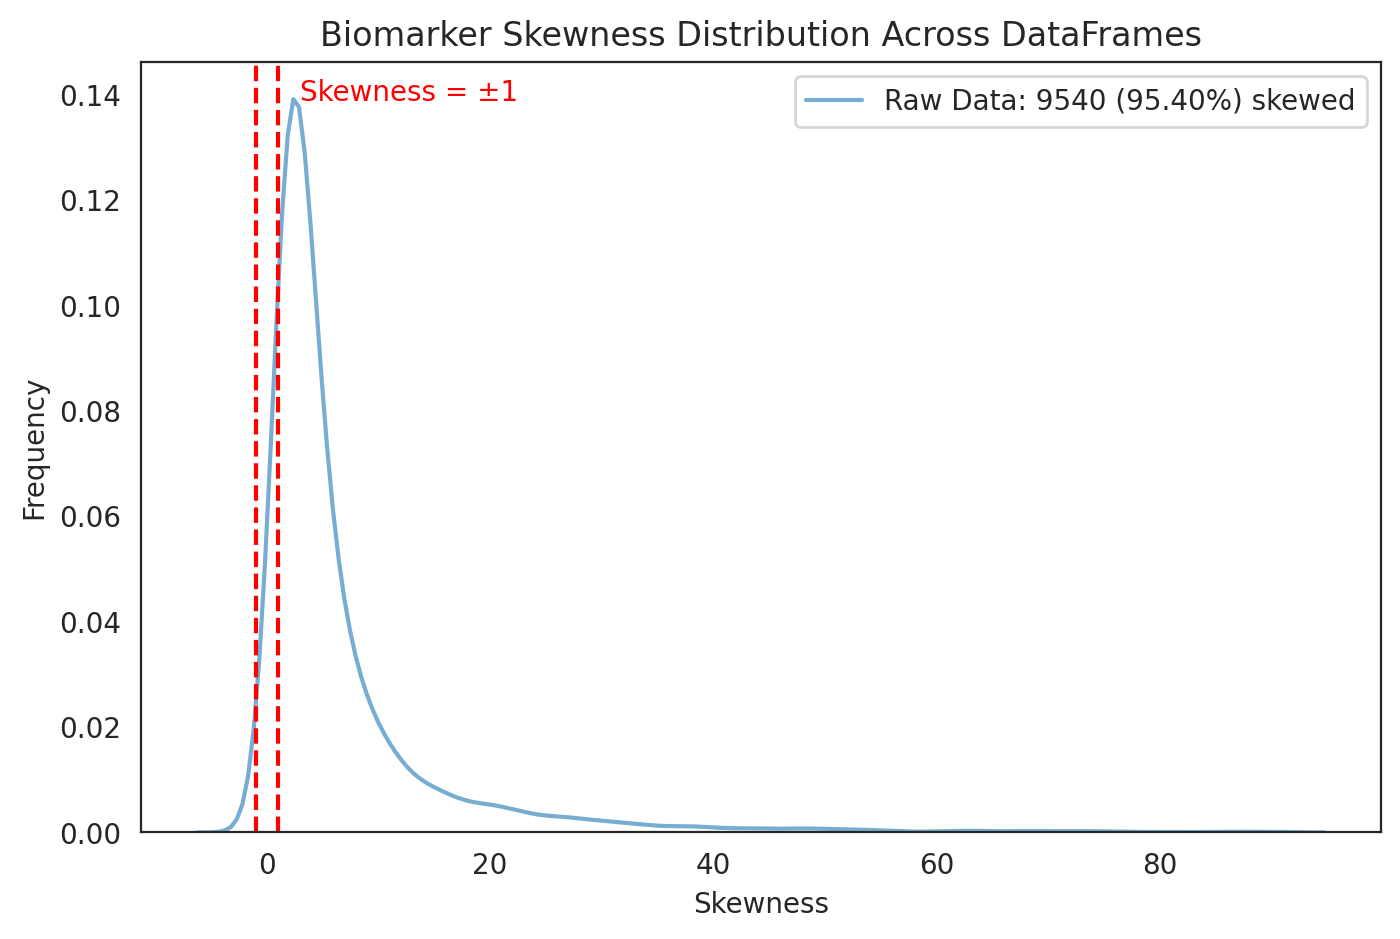

In [10]:
plot_biomarker_skewness({
    'Raw Data': raw_df[biomarker_cols],
    })

## Categorical Encoding and Data Transformation

In [11]:
# Encode categorical data
transformed_df = raw_df.copy()
transformed_df['sex'] = transformed_df['sex'].map({'male': 1, 'female': 0})
transformed_df['incident_diabetes'] = transformed_df['incident_diabetes'].map({1.0: 1, 0.0: 0})
transformed_df['prevalent_diabetes'] = transformed_df['prevalent_diabetes'].map({1.0: 1, 0.0: 0})

# Log transform biomarkers
transformed_df[biomarker_cols] = transformed_df[biomarker_cols].apply(lambda x: np.log1p(x))

## Evaluate Transformation Effects on Skewness

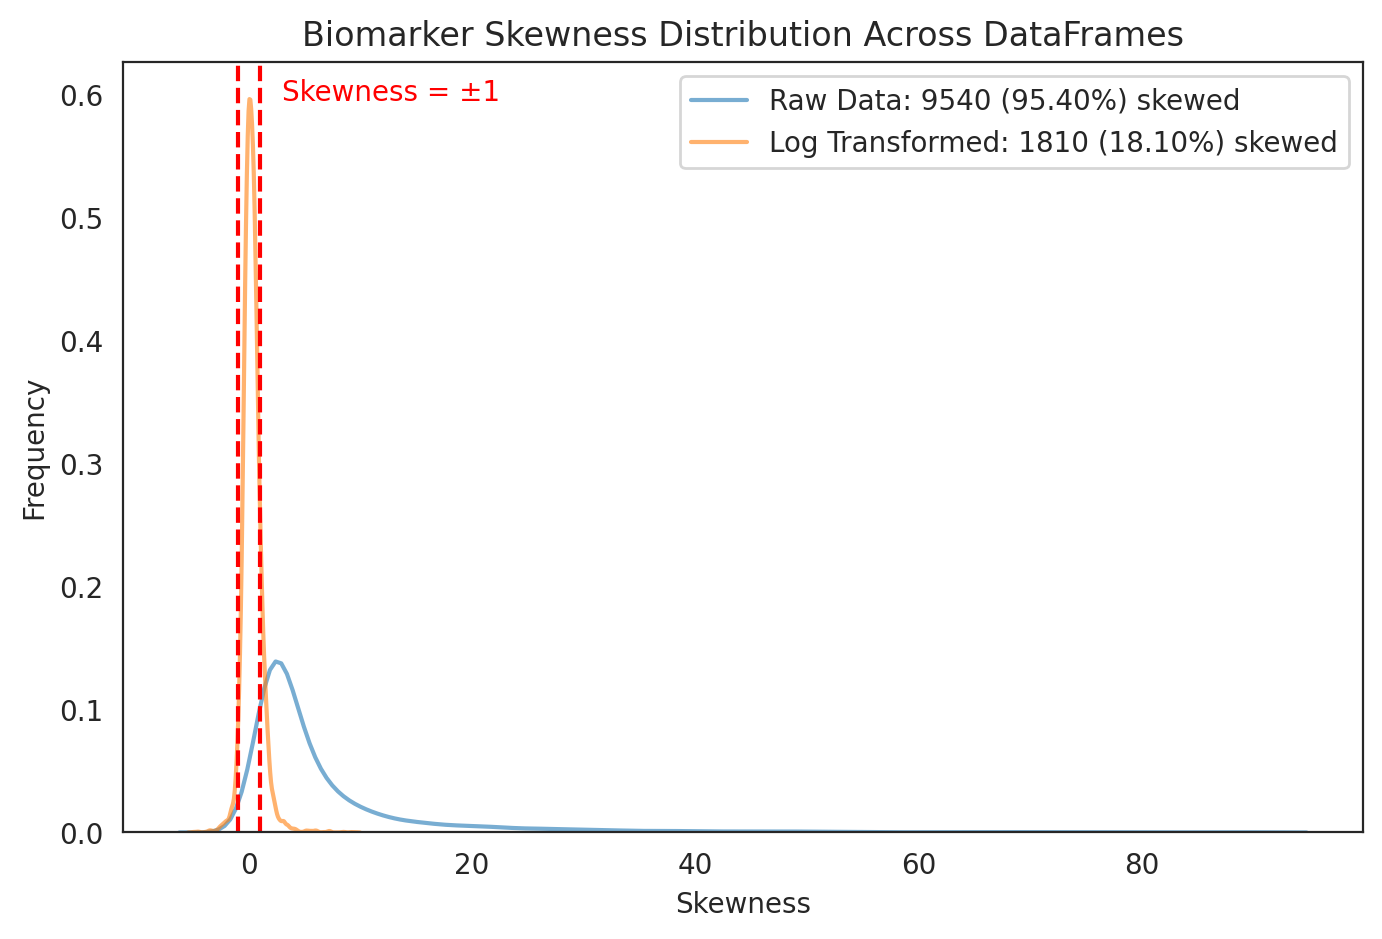

In [12]:
plot_biomarker_skewness({
    'Raw Data': raw_df[biomarker_cols],
    'Log Transformed': transformed_df[biomarker_cols],
    })

## Missing Data Handling

In [13]:
# Data Preprocessing
incident_df = transformed_df.loc[
    (~transformed_df['incident_diabetes'].isna()) & 
    (~transformed_df['prevalent_diabetes'].isna()) & 
    (transformed_df['prevalent_diabetes'] == 0) & 
    (transformed_df['diabetes_followup_time'] > 0)
].drop(columns = ['prevalent_diabetes']).copy()

### Multivariate Imputation

In [14]:
X_imputed_df = impute_data(
    imputed_file_path=f"{main_dir}/data/processed/incident_imputed_df.pkl",
    transformed_df=incident_df,
    missing_threshold=0.3,
    exclude_cols=['incident_diabetes', 'diabetes_followup_time'],
    imputer_kwargs={'max_iter': 3,
                    'n_nearest_features': 200,
                    'random_state': my_random_seed,
                    'verbose': 2
                   },
    integer_cols=['sex', 'prevalent_diabetes']
)

2024-09-24 00:42:07,698 - INFO - /mnt/stsi/stsi1/sfchen/240917_sapientbio_diabetes_biomarker_project/data/processed/incident_imputed_df.pkl: File exists. Loading imputed data...


### (Optional) Random Forest-Based Multivariate Imputation

In [15]:
rf_X_imputed_df = impute_data(
    imputed_file_path=f"{main_dir}/data/processed/rf_incident_imputed_df.pkl",
    transformed_df=incident_df,
    missing_threshold=0.3,
    exclude_cols=['incident_diabetes', 'diabetes_followup_time'],
    imputer_kwargs={'max_iter': 3,
                    'n_nearest_features': 50,
                    'random_state': my_random_seed,
                    'verbose': 2
                   },
    integer_cols=['sex', 'prevalent_diabetes'],
    estimator=RandomForestRegressor(
        n_estimators=50,
        random_state=my_random_seed,
        n_jobs=-1
    )
)

2024-09-24 00:42:07,765 - INFO - /mnt/stsi/stsi1/sfchen/240917_sapientbio_diabetes_biomarker_project/data/processed/rf_incident_imputed_df.pkl: File exists. Loading imputed data...


# Exploratory Data Analysis (EDA)

## Demographic and Physical Distributions

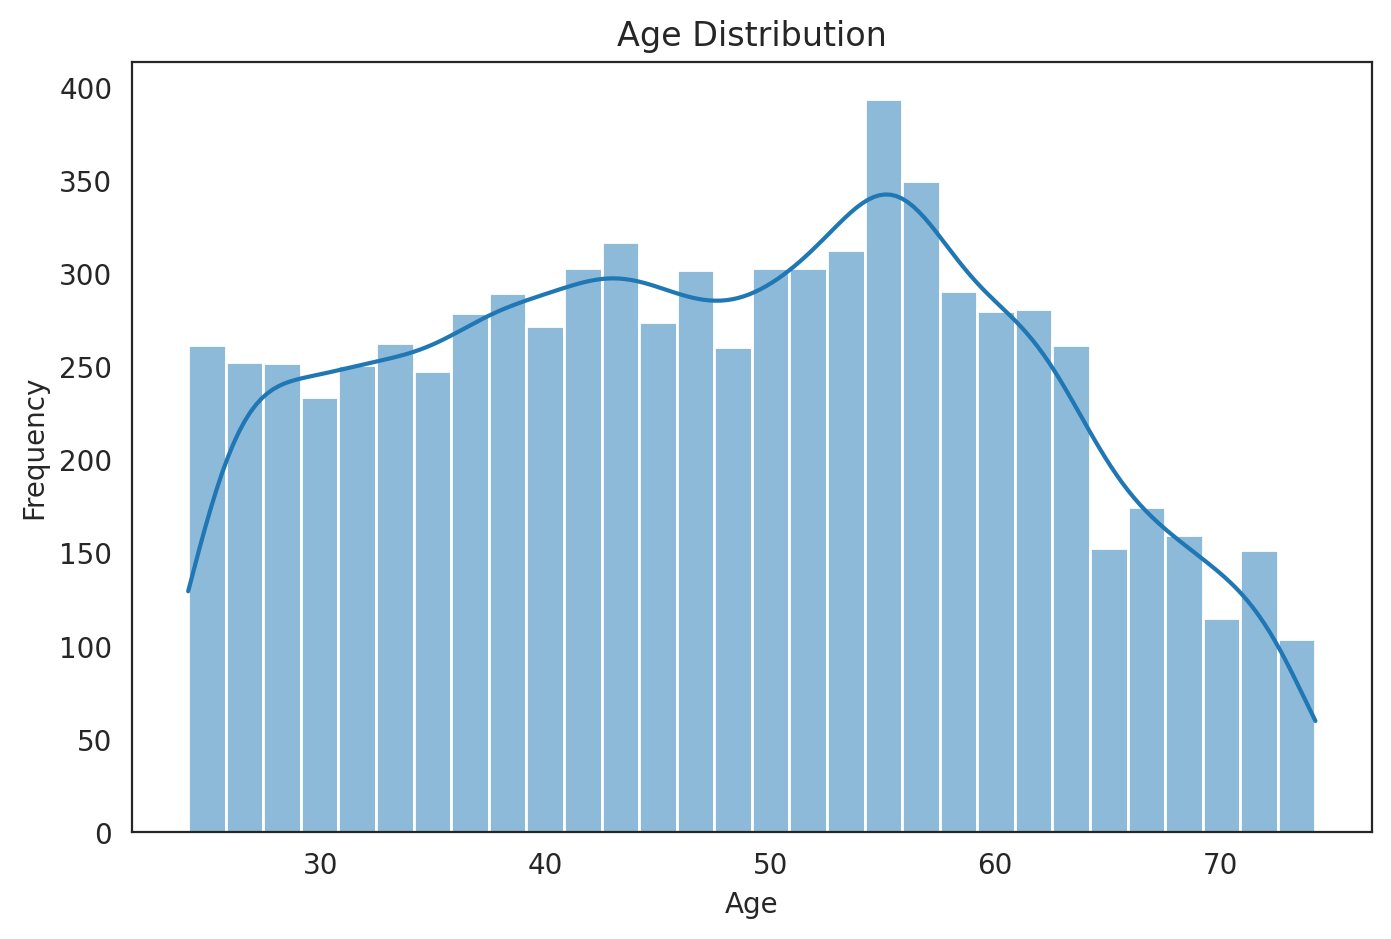

In [16]:
# Age Distribution
plot_distribution(
    data=X_imputed_df, 
    column='age', 
    xlabel='Age',
    plot_type='histplot',
    bins=30,
    title="Age Distribution"
)

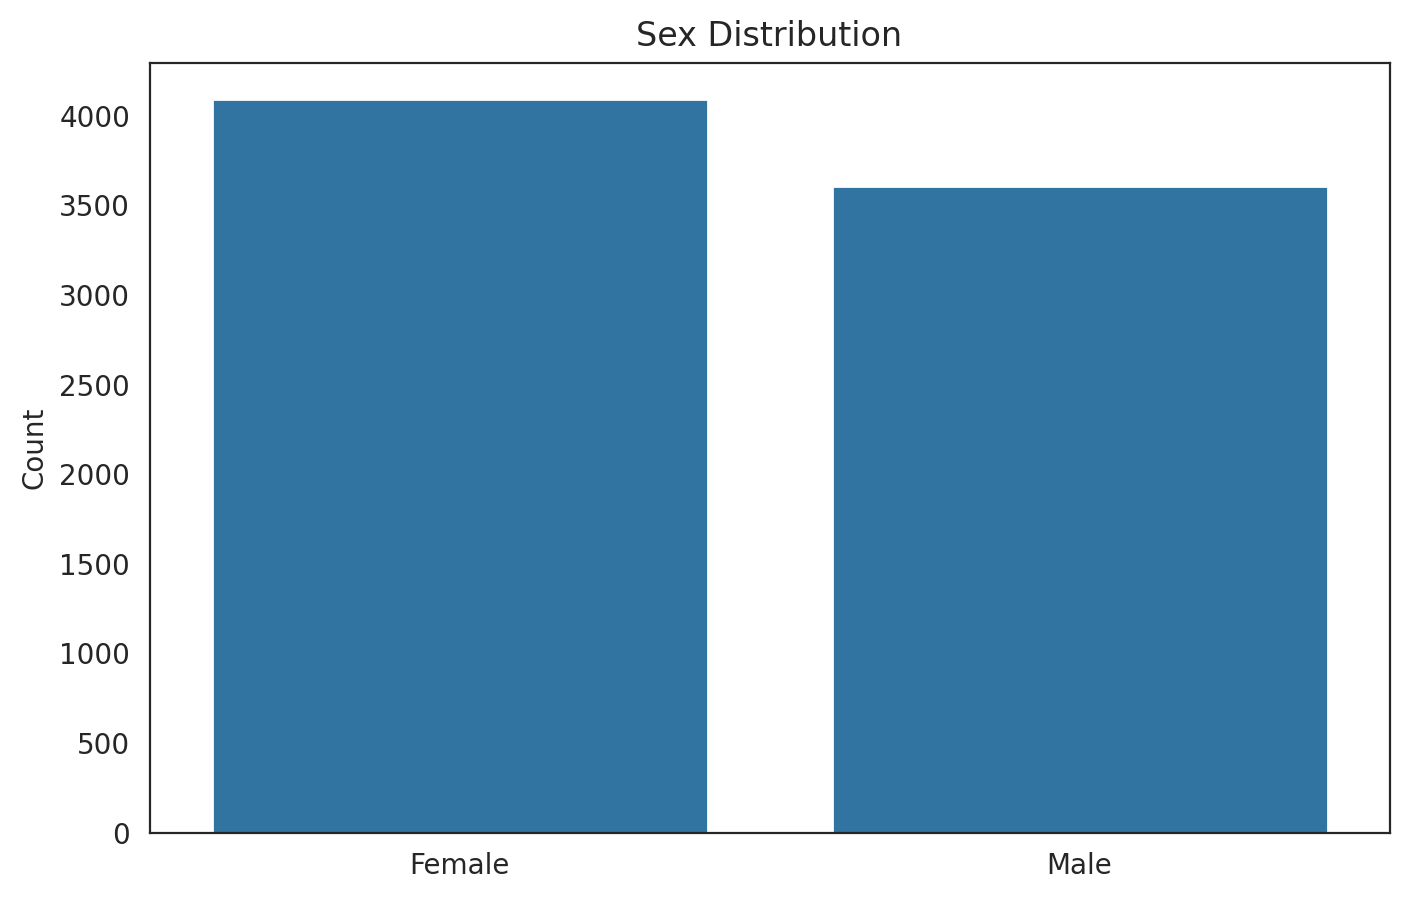

In [17]:
# Sex Distribution
plot_distribution(
    data=X_imputed_df, 
    column='sex', 
    plot_type='countplot',
    xticks=['Female', 'Male'],
    title="Sex Distribution"
)

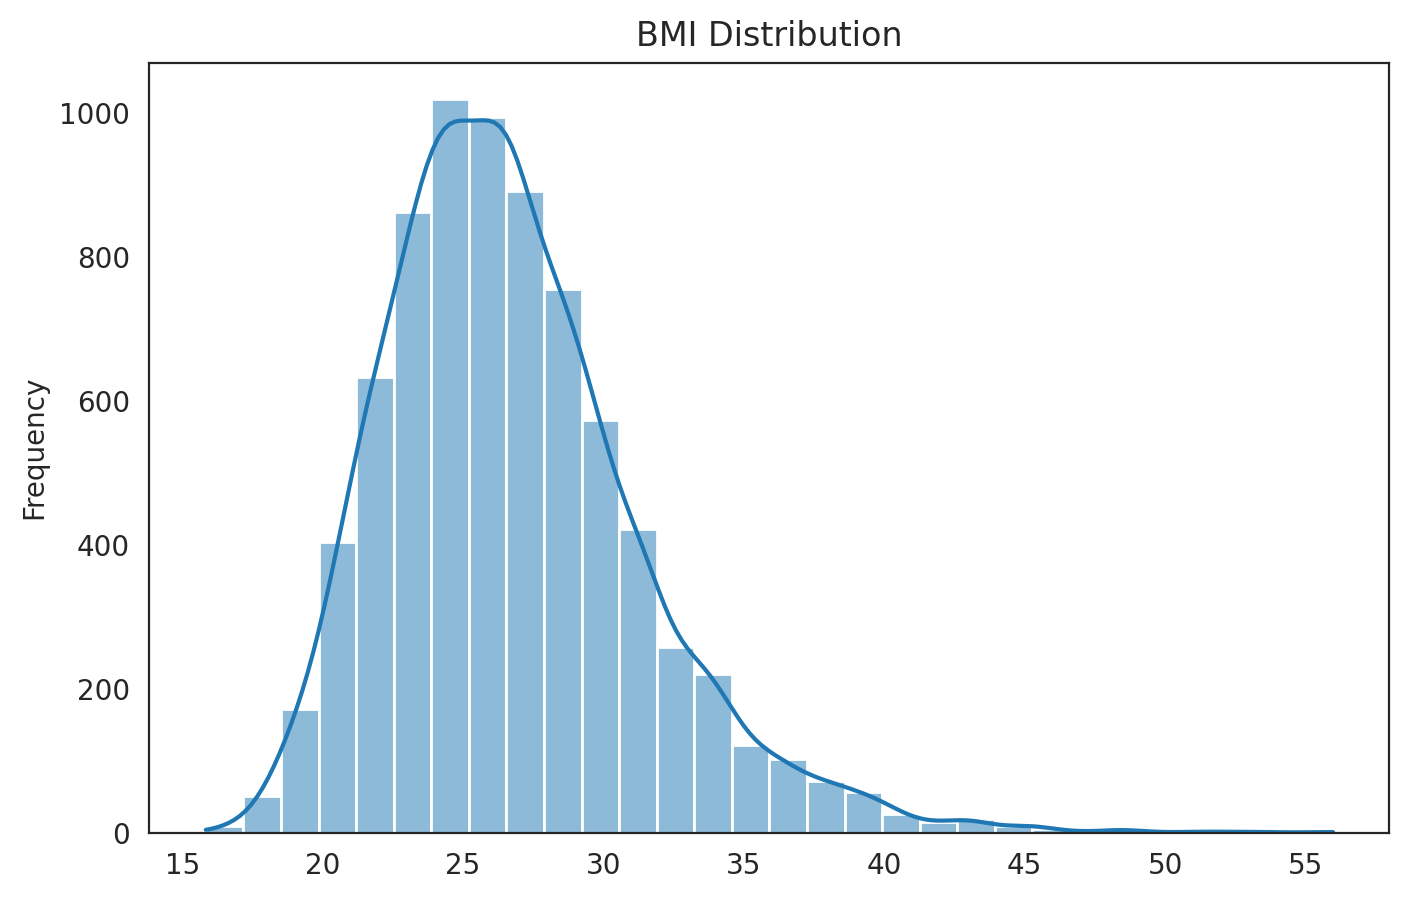

In [18]:
# BMI Distribution
plot_distribution(
    data=X_imputed_df, 
    column='BMI', 
    plot_type='histplot',  # Automatically histplot because 'BMI' is numeric
    bins=30,
    title='BMI Distribution'
)

# Identifying Blood Biomarkers Associated with Incident Diabetes

## Data Preprocessing and Propensity Score Matching

In [19]:
imputed_biomarker_cols = [col for col in X_imputed_df.columns if re.search(biomarker_pattern, col)]

# cleaned_df = cleaned_df.dropna(subset=['incident_diabetes']).copy()
matched_data = calculate_propensity_scores(X_imputed_df, ['age', 'sex', 'BMI'], 'incident_diabetes')

# Feature Engineering
matched_data = match_propensity_scores(matched_data, 'incident_diabetes')

## Univariate Logistic Regression on Each Biomarker

In [20]:
# Logistic Regression using multiprocessing (mp) - default with 8 cores (2x faster)
log2_fold_changes, p_values = run_logistic_regression_mp(
    df=matched_data, 
    covariates=['age', 'sex', 'BMI'], 
    outcome_col='incident_diabetes', 
    biomarker_cols=imputed_biomarker_cols
    )

## Correction for Multiple Hypothesis Testing

In [21]:
# Adjust p-values for multiple testing using Benjamini-Hochberg correction
corrected_p_values = adjust_p_values(p_values)

# Identify significant biomarkers based on corrected p-values and fold changes
pval_threshold = -np.log10(0.05)  # p-value < 0.05
fc_threshold = 1  # Log2 fold change threshold
significant_biomarkers = pd.DataFrame({
    'biomarker': imputed_biomarker_cols,
    'log2FC': log2_fold_changes,
    'corrected_p_value': corrected_p_values
}).query(f'abs(log2FC) > {fc_threshold} and corrected_p_value < 0.05')

display(significant_biomarkers)

,biomarker,log2FC,corrected_p_value
661,mtb_0409565,1.077432,1.137871e-04
747,mtb_0465668,1.291822,2.561628e-08
842,mtb_0522146,1.206673,2.068547e-05
1153,mtb_0733731,1.008752,3.080612e-05
1244,mtb_0783395,-1.028322,1.038101e-04
1314,mtb_0822474,-1.105990,6.897179e-04
1348,mtb_0841776,1.169751,2.323185e-02
1629,mtb_0983033,1.210028,3.413436e-02
1786,mtb_1068685,-1.409137,4.628562e-06
1942,mtb_1180322,-1.243046,5.628406e-10


## Volcano Plot of Significant Biomarkers

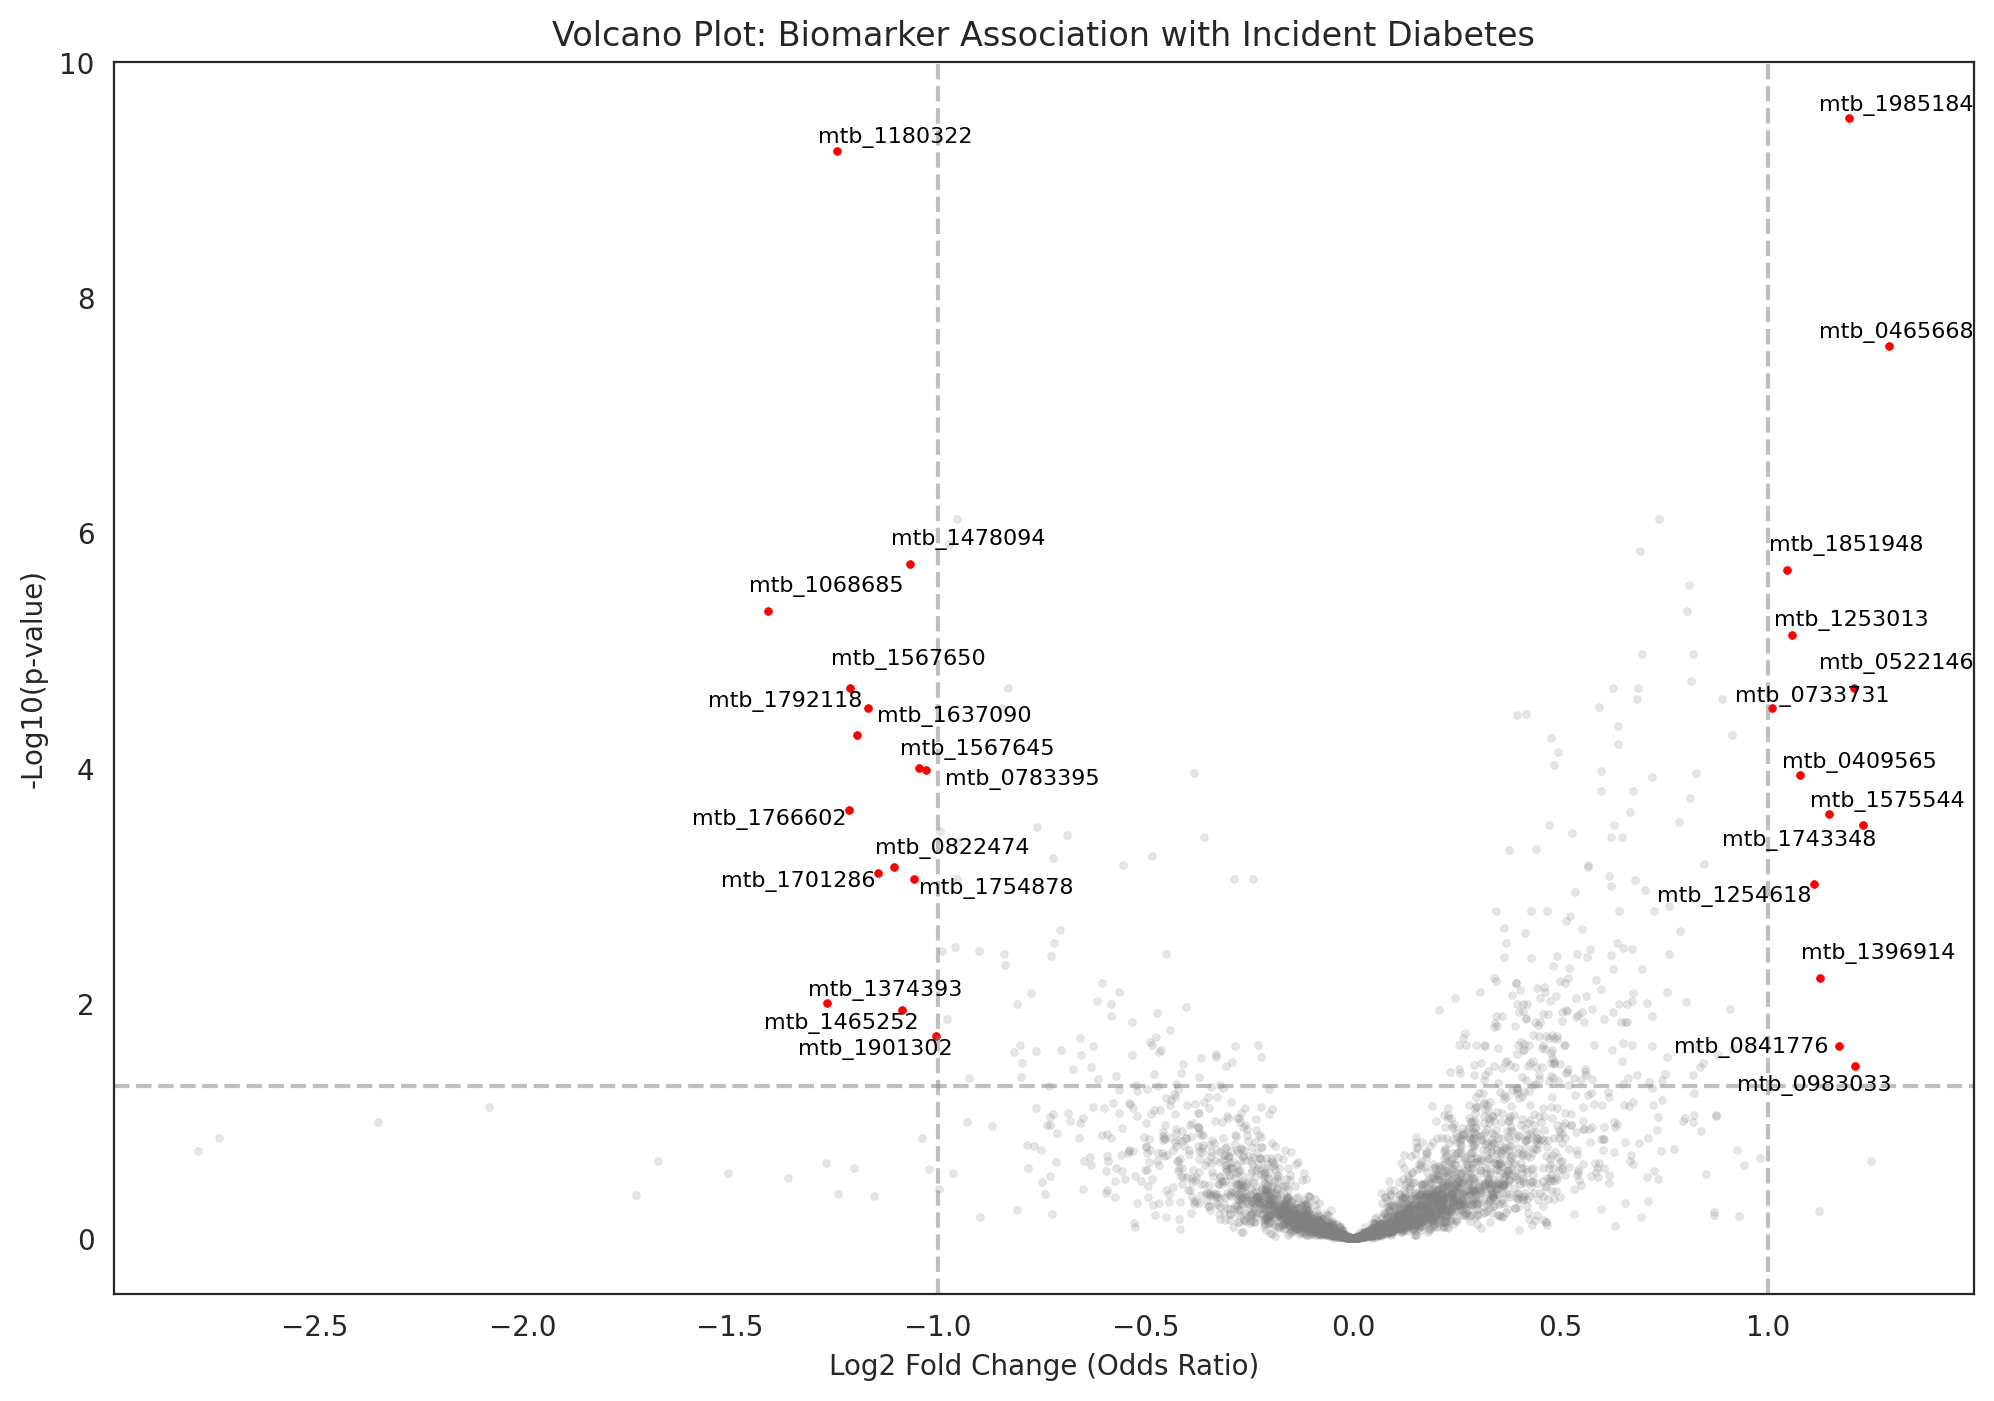

In [22]:
# Volcano plot to visualize significant biomarkers and their associations
plot_volcano(
    imputed_biomarker_cols, 
    log2_fold_changes, 
    corrected_p_values, 
    output_path = f"{main_dir}/reports/figures/volcano_plot.svg"
)

## Multicollinearity Heatmap of Biomarkers

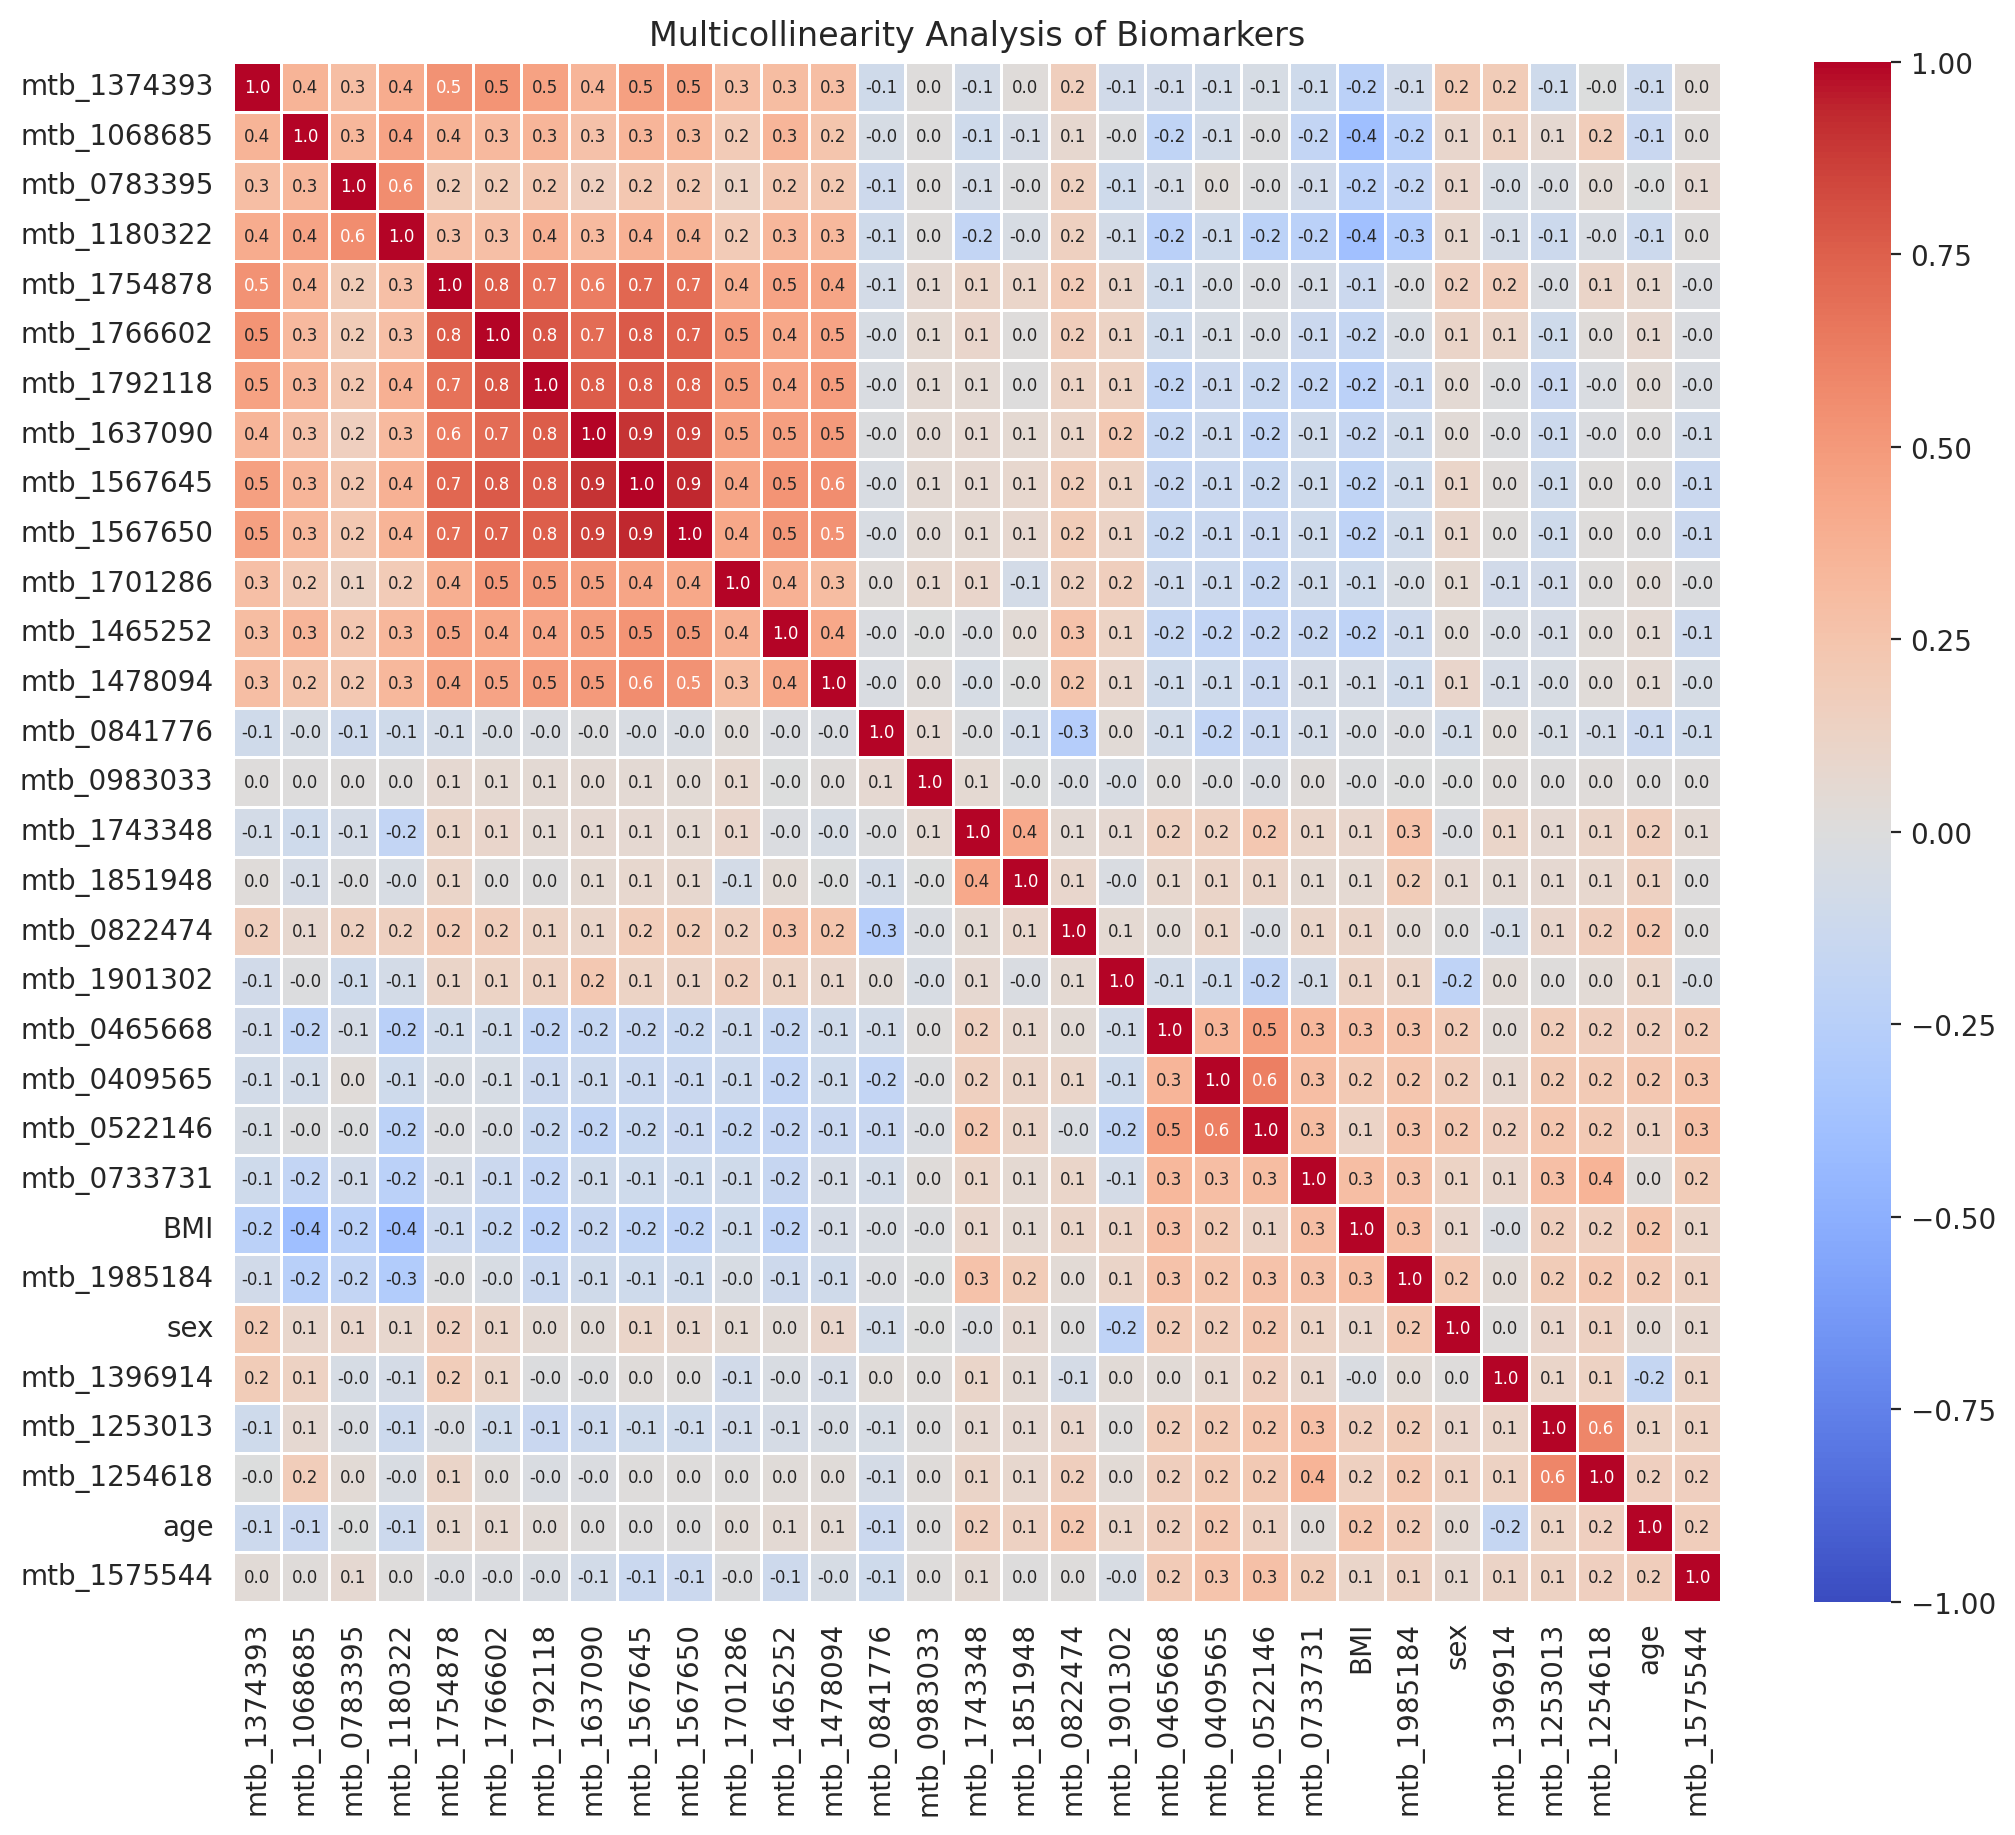

In [23]:
# Select relevant columns including significant biomarkers
target_df = X_imputed_df[['age', 'sex', 'BMI'] + 
                      list(significant_biomarkers['biomarker'])]

# Call the function with `fastcluster` and save the heatmap
plot_multicollinearity_heatmap(
    target_df, 
    output_path=f"{main_dir}/reports/figures/multicollinearity_heatmap_plot.svg"
)

# Building and Evaluating Machine Learning Models

## Data Preparation and Train/Test Split

In [24]:
# Exclude follow-up time as confounder and split cohort into training/testing datasets
X, y = prepare_data(X_imputed_df, 'incident_diabetes', ['diabetes_followup_time'])
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, 
    y, 
    X_imputed_df.index,
    test_size=0.2, 
    stratify=y, 
    random_state=my_random_seed
)

In [25]:
# Target the significant biomarkers
target_X_train = target_df.loc[idx_train]
target_X_test = target_df.loc[idx_test]

## Model Screening and Selection (Logistic Regression Focus)

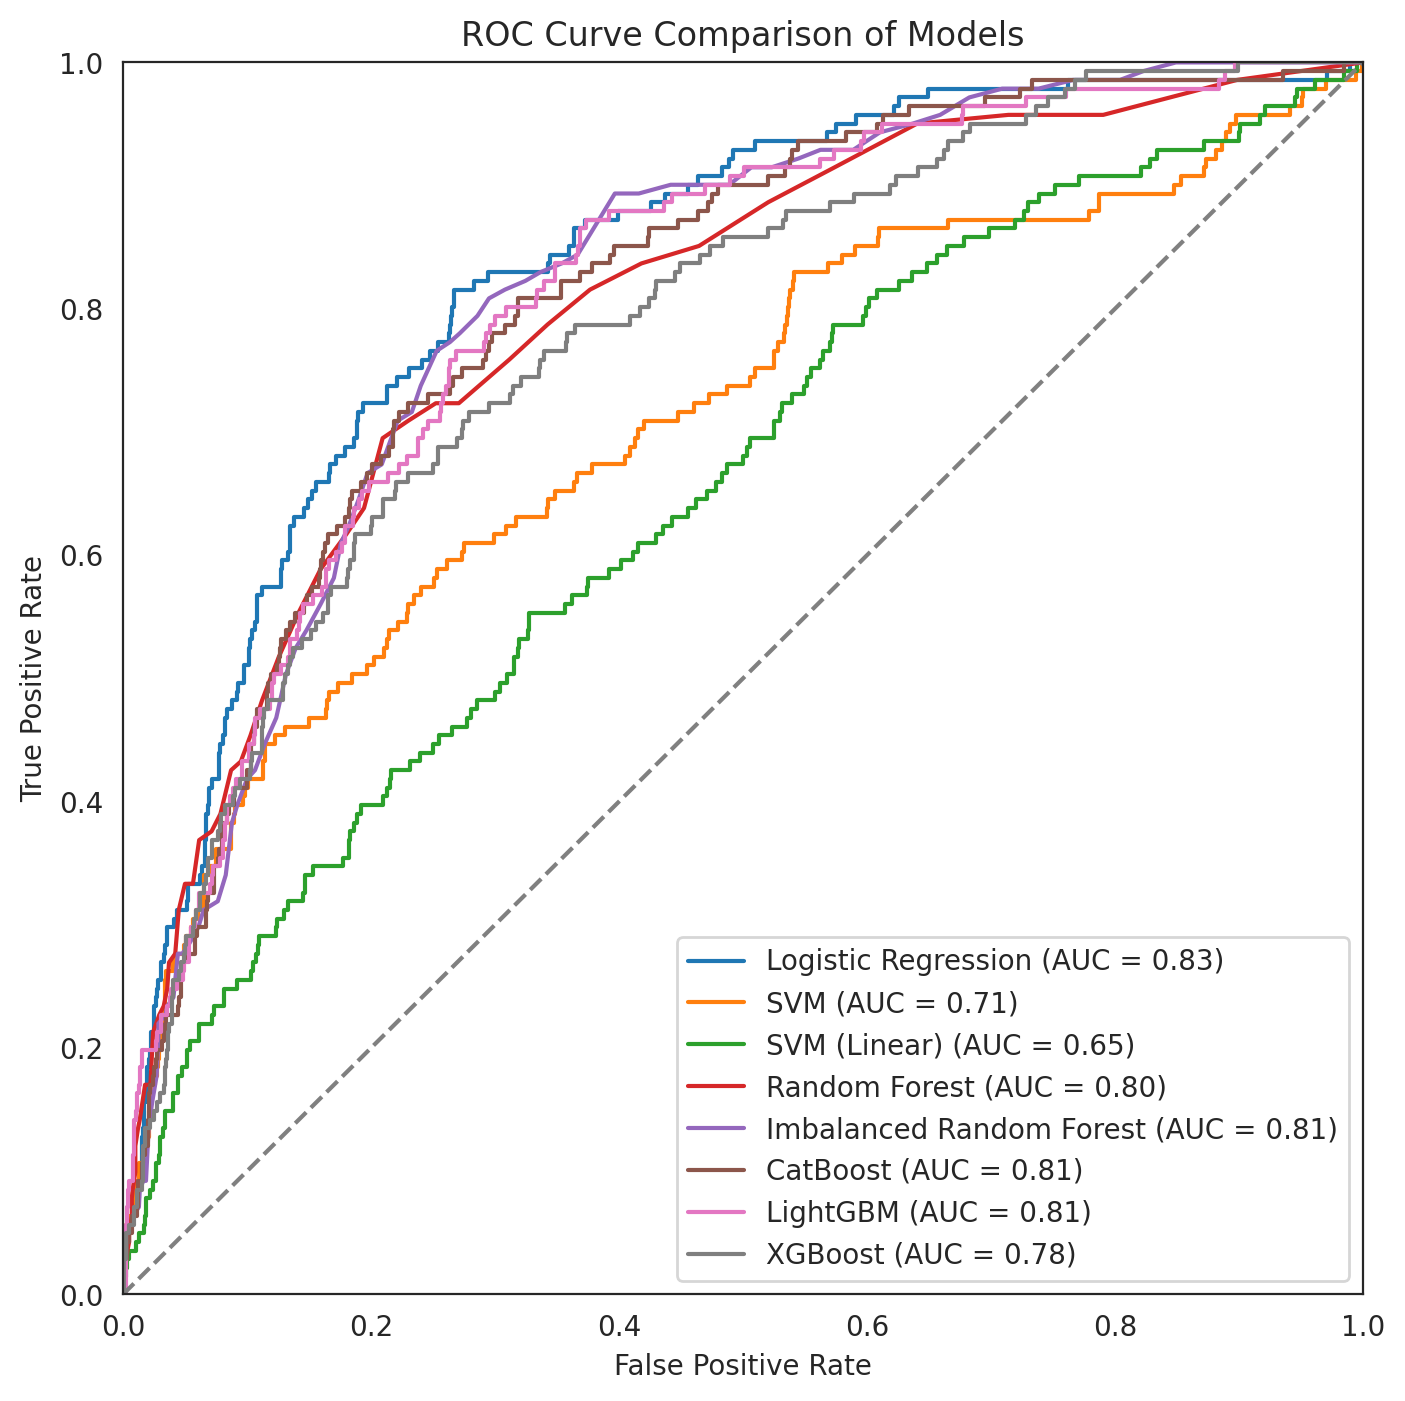

In [26]:
# List of models to evaluate
models = {
    'Logistic Regression': LogisticRegression(
        solver='liblinear'
    ),
    'SVM': SVC(
        probability=True
    ),
    'SVM (Linear)': SVC(kernel='linear', probability=True),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        random_state=my_random_seed
    ),
    'Imbalanced Random Forest': BalancedRandomForestClassifier(
        n_estimators=100,
        random_state=my_random_seed,
        sampling_strategy='all',
        replacement = True,
        bootstrap = False
    ),
    'CatBoost': CatBoostClassifier(
        verbose=0,
        random_state=my_random_seed
    ),
    'LightGBM': LGBMClassifier(random_state=my_random_seed,
                               verbose=-1
                              ),
    'XGBoost': XGBClassifier(eval_metric='logloss',
                             random_state=my_random_seed
                            )
}

# Get predict probabilities for all the selected models with target features
prediction_probs = get_prediction_probabilities(
    models, 
    target_X_train, 
    y_train, 
    target_X_test
)

# Plot ROC Curve for comparison
plot_roc_curves(prediction_probs, y_test)

## Linear Model: Baseline and Optimizations

### Logistic Regression: Initial Model Evaluation

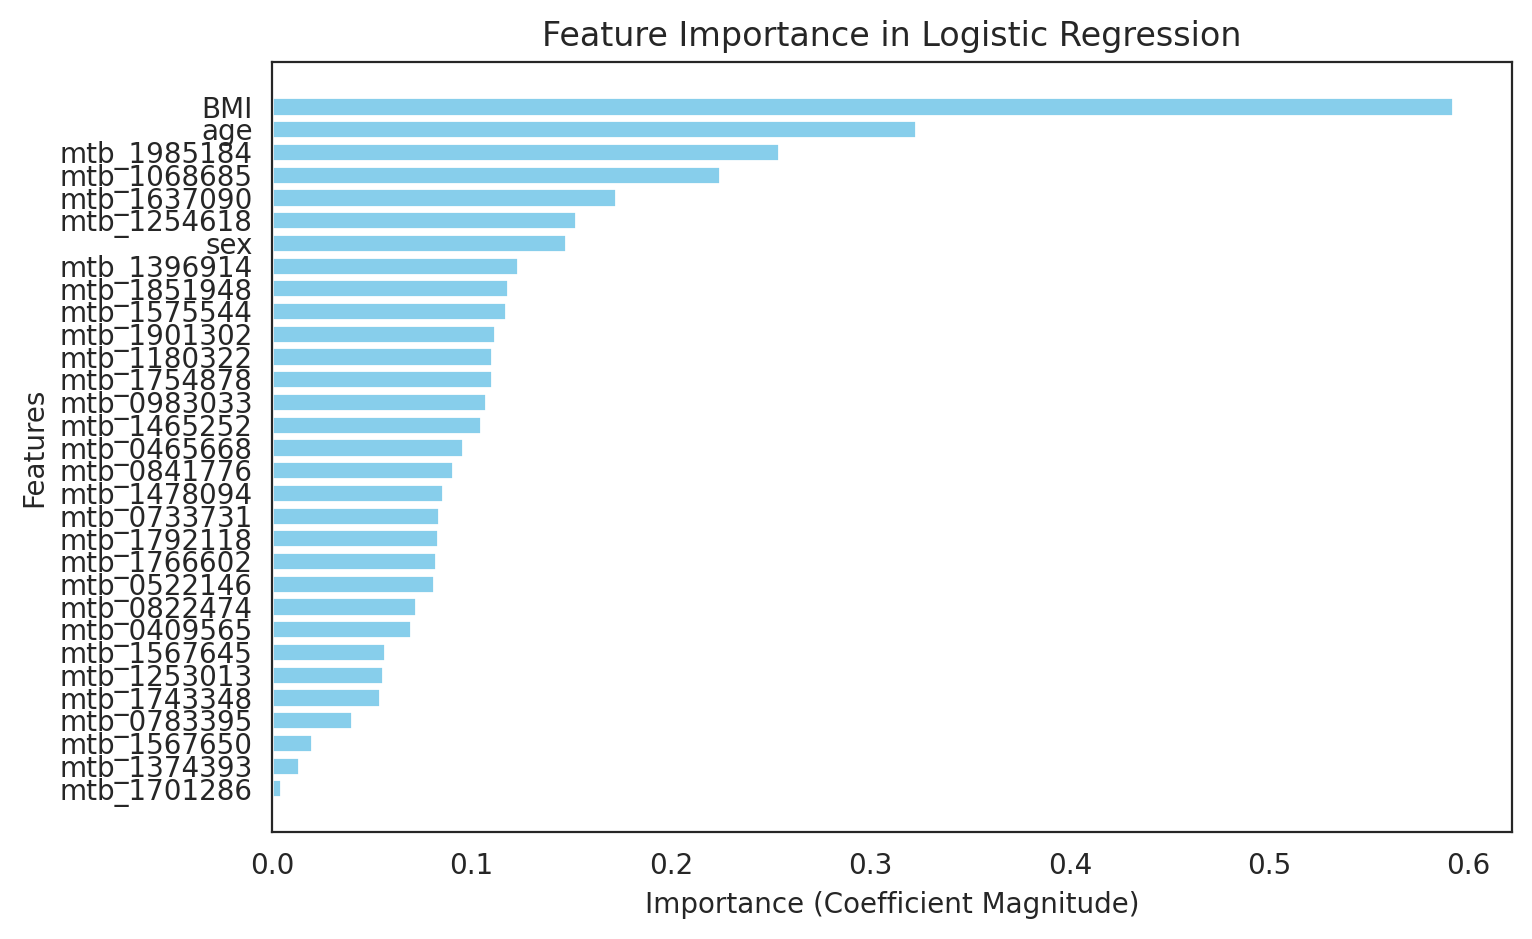

In [27]:
# Train the logistic regression with significant features and show feature importance
logreg_PIP = exec_basic_logreg(
    target_X_train, 
    y_train, 
    random_state=my_random_seed
)

In [28]:
# Evaluate the logistic regression with significant features
y_pred_prob = evaluate_model_performance(
    logreg_PIP,
    target_X_test,
    y_test
)

AUC: 0.83
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95      1399
         1.0       0.41      0.08      0.13       141

    accuracy                           0.91      1540
   macro avg       0.66      0.53      0.54      1540
weighted avg       0.87      0.91      0.87      1540

Confusion Matrix:
[[1383   16]
 [ 130   11]]


### Optimizing Logistic Regression: Dropping Highly Correlated Features

In [29]:
# Drop features highly correlated based on ranking of significance to reduce multicollinearity
dropped_features = filter_highly_correlated_features(
    target_df[list(significant_biomarkers['biomarker'])], 
    significant_biomarkers, 
    threshold=0.5 # correlation hreshold for filtering
)
print(f"Drop feature with highly correlated proxies: {dropped_features}")

# Create streamlined datasets reducing multicollinearity
streamlined_X_train = target_X_train.drop(columns=dropped_features)
streamlined_X_test = target_X_test.drop(columns=dropped_features)

Drop feature with highly correlated proxies: ['mtb_1754878', 'mtb_1567645', 'mtb_0783395', 'mtb_1465252', 'mtb_1253013', 'mtb_1637090', 'mtb_1766602', 'mtb_1792118', 'mtb_1478094', 'mtb_0409565']


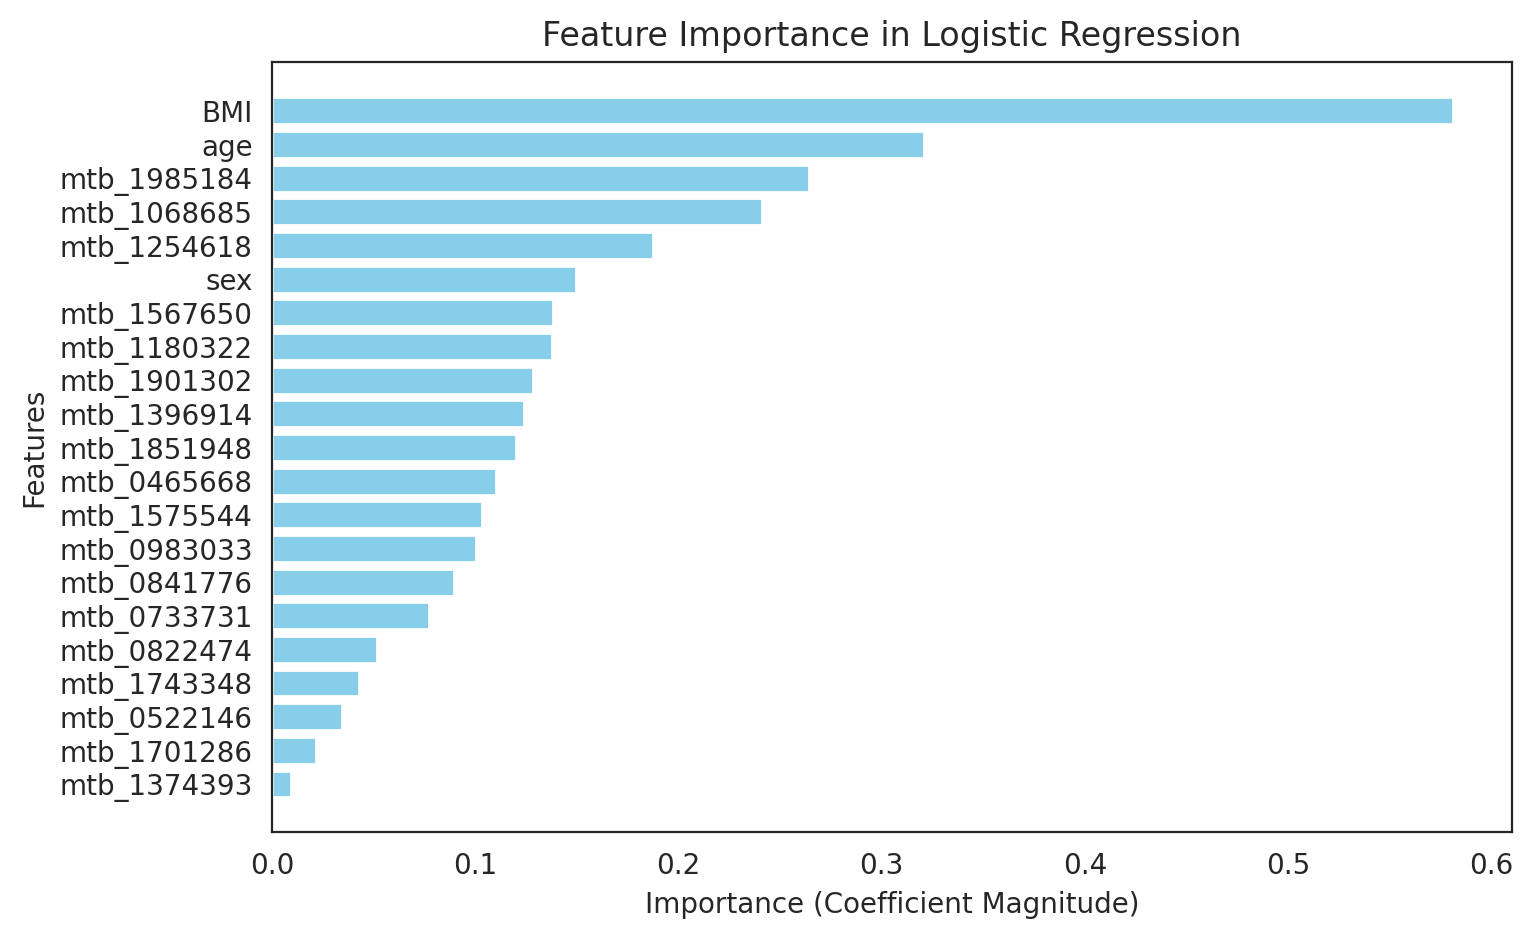

In [30]:
# Train the logistic regression with streamlined feature set and show feature importance
streamlined_logreg_PIP = exec_basic_logreg(streamlined_X_train, y_train)

In [31]:
# Evaluate the logistic regression with streamlined feature set
streamlined_y_pred_prob = evaluate_model_performance(
    streamlined_logreg_PIP,
    streamlined_X_test,
    y_test
)

AUC: 0.83
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95      1399
         1.0       0.50      0.08      0.13       141

    accuracy                           0.91      1540
   macro avg       0.71      0.54      0.54      1540
weighted avg       0.88      0.91      0.88      1540

Confusion Matrix:
[[1388   11]
 [ 130   11]]


### Feature Selection and Hyperparameter Tuning with Cross-Validation

In [ ]:
# Define cross-validation and parameter grid
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=my_random_seed)
param_grid = {
    'estimator__C': [0.1, 1, 10],  # Regularization strength
    'estimator__l1_ratio': [0.7, 0.8, 0.9, 1.0]  # Mixing parameter between L1 and L2
}

# Define the estimator (e.g., Logistic Regression with elasticnet regularization)
estimator = LogisticRegression(penalty='elasticnet', solver='saga', random_state=my_random_seed, max_iter=10000)

# Call the function to optimize the model
optimized_pipeline, rfecv_selected_features, optimized_hyperparams = optimize_linear_model(
    target_X_train, y_train, param_grid, cv, estimator, random_state=my_random_seed
)

In [ ]:
# Show the feature importance of best model with final selected feature set
plot_feature_importance(rfecv_selected_features, 
                        np.abs(optimized_pipeline.named_steps['estimator'].coef_[0]), 
                        importance_metric="Coefficient Magnitude",
                        title="Feature Importance in Optimized Logistic Regression")

In [ ]:
# Evaluate the optimized logistic regression
optimized_y_pred_prob = evaluate_model_performance(
    optimized_pipeline,
    target_X_test[rfecv_selected_features],
    y_test
)

### Baseline Model (Minimal Logistic Regression)

In [ ]:
# Train a model without biomarkers as a baseline for comparison
baseline_logreg_PIP = exec_basic_logreg(X_train[['age', 'sex', 'BMI']], y_train, random_state=my_random_seed)

In [ ]:
baseline_y_pred_prob = evaluate_model_performance(
    baseline_logreg_PIP,
    X_test[['age', 'sex', 'BMI']],
    y_test
)

In [ ]:
bins = [0, .2, .4, .6, .8, 1]
labels = ["<20%", "20-40%", "40-60%", "60-80%", ">80%"]
test_follow_up_time = X_imputed_df['diabetes_followup_time'].loc[idx_test].values
optimized_y_pred_group_labels = pd.qcut(pd.Series(optimized_y_pred_prob).rank(method='first'), q=bins, labels=labels).values

plot_combined(
    y_pred_prob=optimized_y_pred_prob,
    y_test=y_test,
    follow_up_time=test_follow_up_time,
    group_labels=optimized_y_pred_group_labels,
    labels=labels,
    rel_risk_bins=10,
    ylim_cumulative_curve=0.4,
    output_path=f"{main_dir}/reports/figures/optimized_logistic_regression_performance.svg"
)

### Logistic Regression Model Comparison Across Stages

In [ ]:
# Compare logistic regression-based model performance through model optimization
plot_roc_curves(
    {
        "Age+Sex+BMI": baseline_y_pred_prob,
        f"Logistic Regression [{len(target_X_train.columns)} features]": y_pred_prob,
        f"Streamlined Logistic Regression [{len(streamlined_X_train.columns)} features]": streamlined_y_pred_prob,
        f"Optimized Logistic Regression [{len(rfecv_selected_features)} features]": optimized_y_pred_prob,
    }
    , y_test)

## (Optional) Survival-based Model: CoxPH

In [ ]:
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

# Cox Proportional Hazards model
cph = CoxPHFitter()

survival_cols = list(rfecv_selected_features) + ['incident_diabetes', 'diabetes_followup_time']

# Fit the model
cph.fit(X_imputed_df.loc[idx_train][survival_cols], 
        duration_col='diabetes_followup_time',
        event_col='incident_diabetes')

# # Print summary of the model
cph.print_summary()

In [ ]:
# Predict partial hazard ratios for new data
predicted_hr = cph.predict_partial_hazard(
    X_imputed_df.loc[idx_test][survival_cols]
)

# Plotting survival function
cph.plot()

In [ ]:
# Concordance Index for the test set (higher is better)
c_index = concordance_index(
    X_imputed_df.loc[idx_test]['diabetes_followup_time'],
    -predicted_hr,
    X_imputed_df.loc[idx_test]['incident_diabetes'])

print(f"Concordance Index: {c_index:.2f}")

## (Optional) XGBoost Model and SHAP-Based Feature Importance Analysis

In [ ]:
# Exclude follow-up time as confounder and split cohort into training/testing datasets
rf_X, rf_y = prepare_data(rf_X_imputed_df, 'incident_diabetes', ['diabetes_followup_time'])
rf_X_train = X_train.loc[idx_train]
rf_X_test = X_test.loc[idx_test]
rf_y_train = y_train.loc[idx_train]
rf_y_test = y_test.loc[idx_test]

### XGBoost: Initial Model Evaluation

In [ ]:
xgb_PIP = Pipeline([
    ('XGBoost', XGBClassifier(eval_metric='logloss', random_state=my_random_seed))
])

# Step 4: Train the model
xgb_PIP.fit(rf_X_train, rf_y_train)

xgb_y_pred_prob = evaluate_model_performance(
    xgb_PIP,
    rf_X_test,
    rf_y_test
)

### SHAP Feature Importance

In [ ]:
# Execute shap tree explainer to get SHAP values for tree-based model
xgb_explainer = shap.TreeExplainer(xgb_PIP[0])
xgb_shap_values = xgb_explainer.shap_values(rf_X_test)

In [ ]:
shap.summary_plot(xgb_shap_values, rf_X_test, max_display = 10, show = True)

In [ ]:
# Plot feature importance ranked by mean absolute SHAP value
xgb_feature_importance = abs(xgb_shap_values).mean(axis=0)

plot_feature_importance(list(rf_X_test.columns), 
                        xgb_feature_importance, 
                        importance_metric="Mean absolute SHAP value",
                        title="Feature importance of prevalent diabetes prediction by XGBoost")

In [ ]:
# Selected the top 5 important features based on SHAP feature importance
xgb_shap_importance_df = pd.DataFrame(
    {
        "Feature": list(rf_X_test.columns),
        "Importance": xgb_feature_importance
    }
).sort_values(by='Importance', ascending=False)

xgb_shap_select_cols = list(xgb_shap_importance_df.head(4)['Feature'].values)

In [ ]:
optimized_xgb_PIP = optuna_optimize_xgb(
    X_train=rf_X_train[xgb_shap_select_cols],
    y_train=rf_y_train,
    random_state=my_random_seed)

In [ ]:
optimized_xgb_y_pred_prob = evaluate_model_performance(
    optimized_xgb_PIP,
    rf_X_test[xgb_shap_select_cols],
    rf_y_test
)

In [ ]:
bins = [0, .2, .4, .6, .8, 1]
labels = ["<20%", "20-40%", "40-60%", "60-80%", ">80%"]
test_follow_up_time = rf_X_imputed_df['diabetes_followup_time'].loc[idx_test].values
best_xgb_y_pred_group_labels = pd.qcut(pd.Series(best_xgb_y_pred_prob).rank(method='first'), q=bins, labels=labels).values

plot_combined(
    y_pred_prob=optimized_xgb_y_pred_prob,
    y_test=rf_y_test,
    follow_up_time=test_follow_up_time,
    group_labels=best_xgb_y_pred_group_labels,
    labels=labels,
    rel_risk_bins=10,
    ylim_cumulative_curve=0.4,
    output_path=f"{main_dir}/reports/figures/optimized_xgboost_performance.svg"
)

# 

In [ ]:
print(rfecv_selected_features)
print(xgb_shap_select_cols)

In [ ]:
# Plot a Venn diagram to show the overlap between the three sets
plt.figure(figsize=(8, 8))
venn2([set(rfecv_selected_features), set(xgb_shap_select_cols)], 
      set_labels=('RFECV-selected features\n(Logistic Regression)', 'SHAP-selected features\n(XGBoost)'))

plt.title("Venn Diagram of Overlapping Features")
plt.show()

# Report

## Method

In [ ]:
## Data Splitting
## Model Training
## Model Evaluation
### ROC AUC Score
### Classification Report
### Confusion Matrix
## ROC Curve

## Results

## Discussion

1. The study cohort has relative higher overall case rate (13.9%) at the end of follow-up period than general Americans in 2021 (11.6%) according to AHA (https://diabetes.org/about-diabetes/statistics/about-diabetes).
2. Imputation could be fine-tuned with more iterations and nearest neighbors while coming with higher computaitonal complexity.
3. Suvival-based model could be considered.


- Interpretation of Significant Biomarkers
- Model Performance
- Limitations: sample size. more physcial measurment or lab tests. Other cormorbidity.

## Conclusion and Future Work

## References